In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
pip install -U object-detection-fastai

     |████████████████████████████████| 317kB 13.9MB/s 
     |████████████████████████████████| 51.0MB 59kB/s 
  Created wheel for openslide-python: filename=openslide_python-1.1.2-cp37-cp37m-linux_x86_64.whl size=27665 sha256=504985b35a089bb0dcbfb964731769e9a3df06f182fd36712b355748e92e94fa
  Stored in directory: /root/.cache/pip/wheels/6b/55/74/ba9d3dcc2c5c0f1282e08bae70df0ed57b496fb6b5c8f1adc9
Successfully built openslide-python
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [5]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [6]:
from object_detection_fastai.helper.object_detection_helper import *
from object_detection_fastai.loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from object_detection_fastai.models.RetinaNet import RetinaNet
from object_detection_fastai.callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric

In [109]:
cars = untar_data("https://github.com/wargreymon89/ObjectDetection/raw/master/data/cars", force_download=True)
images, lbl_bbox = get_annotations(cars/'annotations/train_sample.json')
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

A new version of the dataset is available.


In [110]:
size = 256

In [111]:
data = (ObjectItemList.from_folder(cars)
        #Where are the images? -> in cars
        .split_by_rand_pct()
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func
        .transform(get_transforms(), tfm_y=True ,size=size)
        #Data augmentation? -> Standard transforms with tfm_y=True
        .databunch(bs=6, collate_fn=bb_pad_collate))
        #Finally we convert to a DataBunch and we use bb_pad_collate
#data = data.normalize()

In [112]:
data

ImageDataBunch;

Train: LabelList (29 items)
x: ObjectItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ObjectCategoryList
ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256)
Path: /root/.fastai/data/cars;

Valid: LabelList (7 items)
x: ObjectItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ObjectCategoryList
ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256)
Path: /root/.fastai/data/cars;

Test: None

In [113]:
data.show_batch(rows=13, ds_type=DatasetType.Train, figsize=(15,15))

In [42]:
data.classes

['background', 'sign']

In [ ]:
[1,2**(1/3), 2**(2/3)]

[1, 1.2599210498948732, 1.5874010519681994]

In [34]:
anchors = create_anchors(sizes=[(32,32),(16,16),(8,8),(4,4)], ratios=[0.25, 0.5, 1], scales=[1.8, 2, 0.6, 1, 1.25, 1.6])

In [32]:
len(anchors)

24480

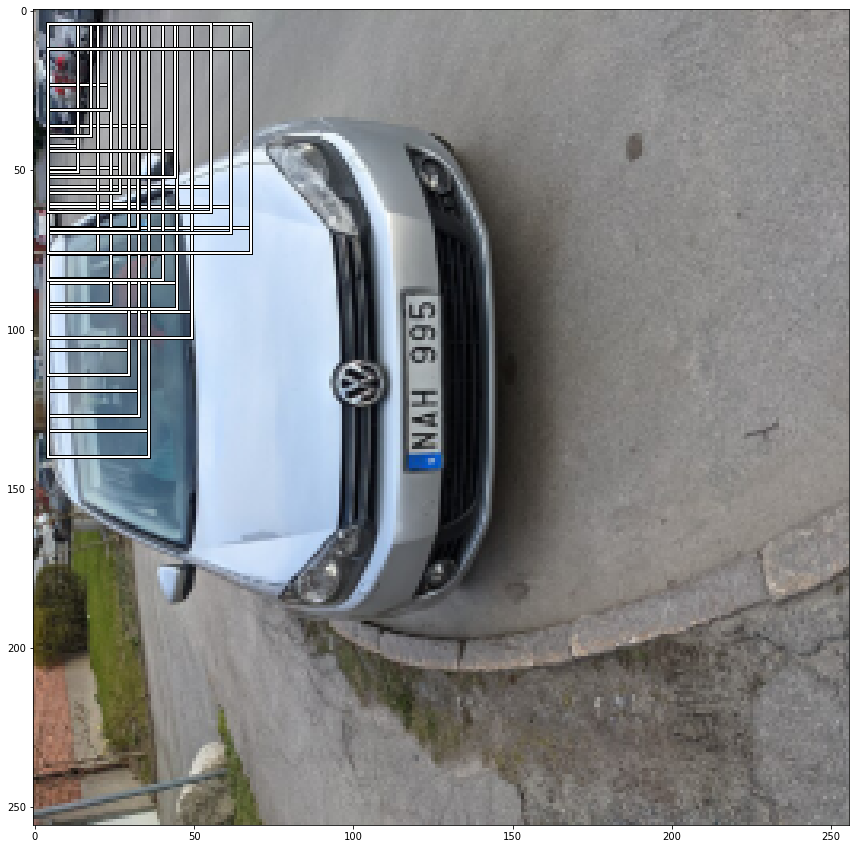

In [56]:
fig,ax = plt.subplots(figsize=(15,15))
ax.imshow(image2np(data.valid_ds[0][0].data))

for i, bbox in enumerate(anchors[:36]):
    bb = bbox.numpy()
    x = (bb[0] + 1) * size / 2 
    y = (bb[1] + 1) * size / 2 
    w = bb[2] * size / 2
    h = bb[3] * size / 2
    
    rect = [x,y,w,h]
    draw_rect(ax,rect)

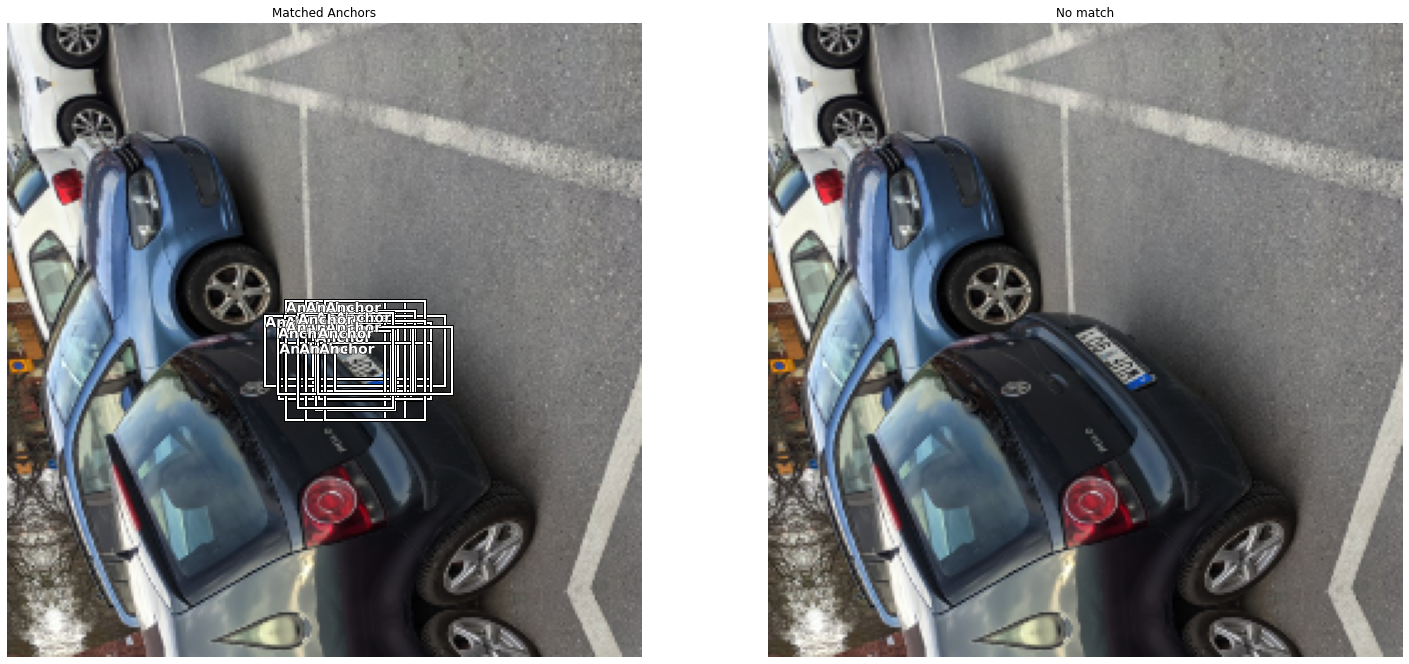

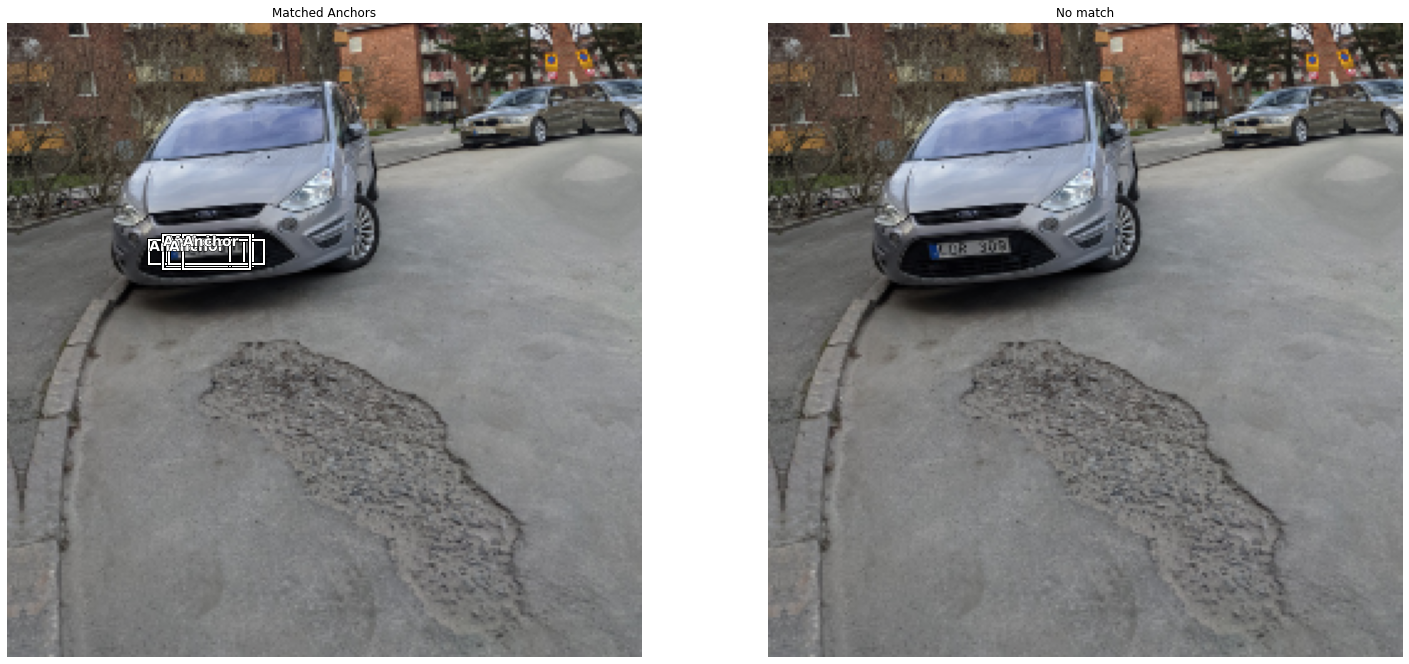

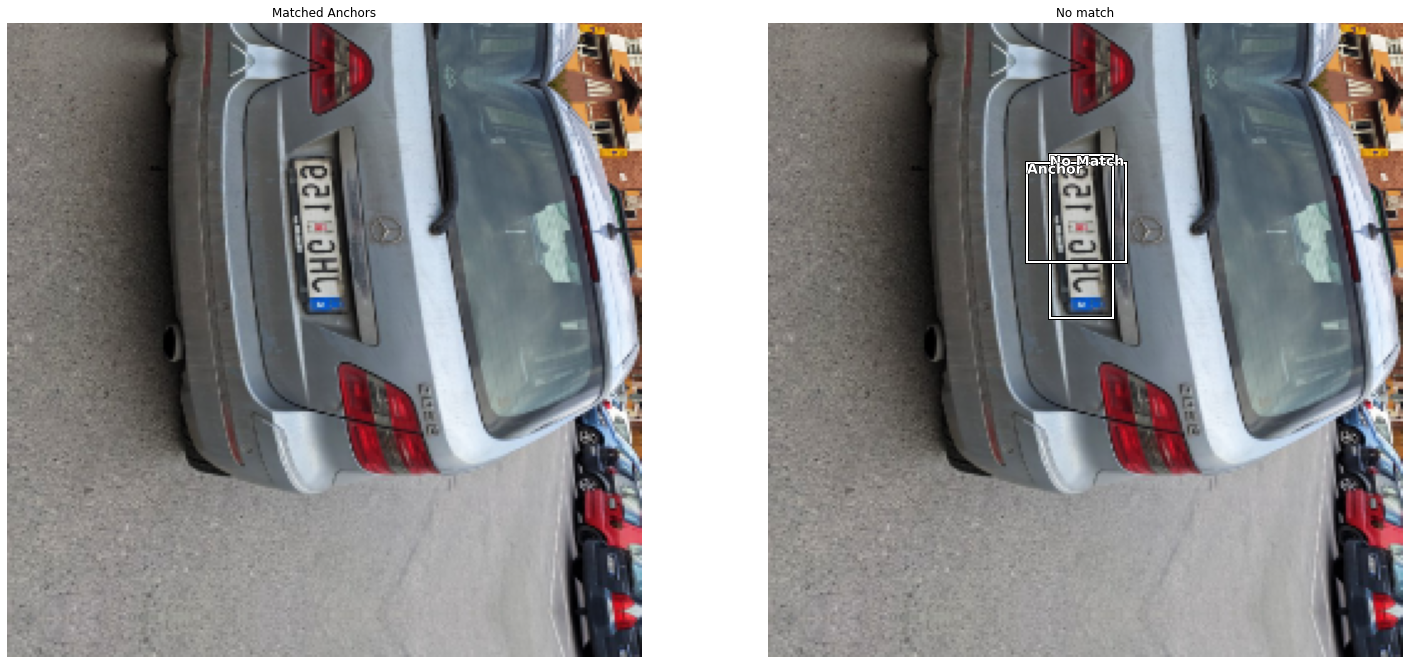

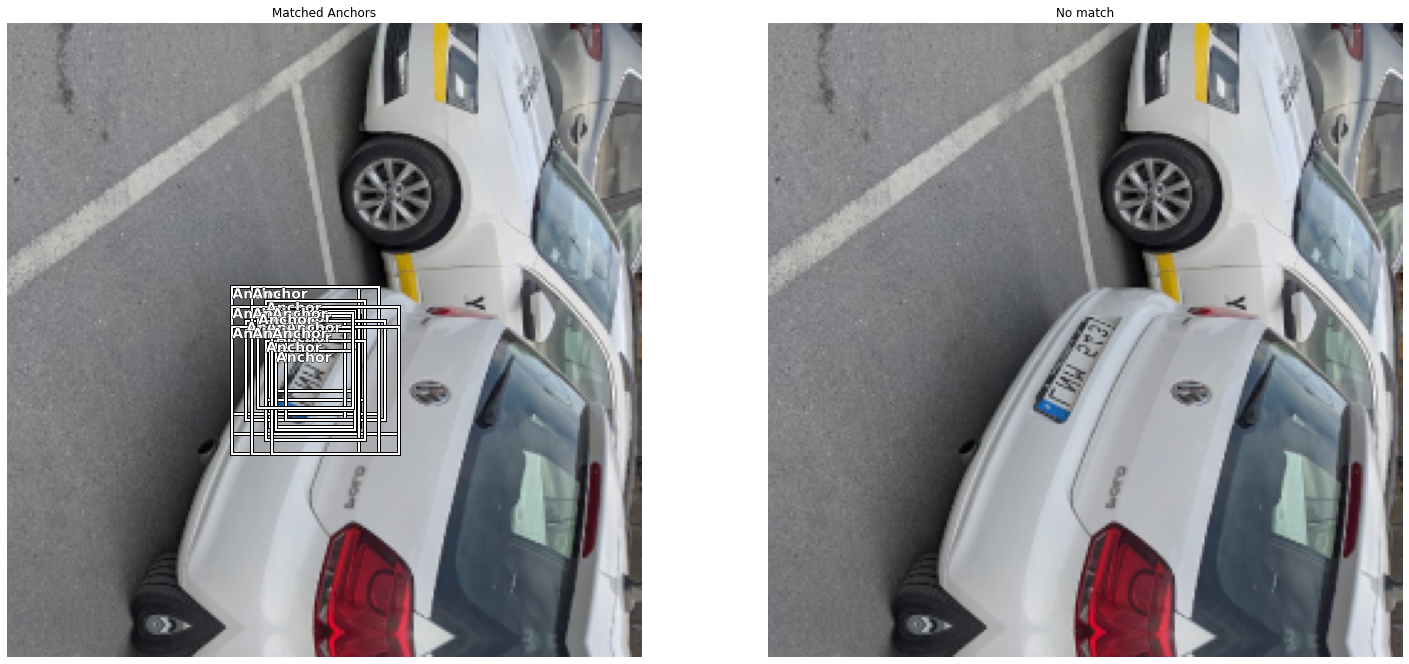

In [57]:
all_boxes, all_labels = show_anchors_on_images(data, anchors, figsize=(25,25))

In [43]:
data.train_ds.c

2

In [44]:
n_classes = data.train_ds.c

crit = RetinaNetFocalLoss(anchors)

encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=18, sizes=[32,16,8,4], chs=32, final_bias=-4., n_conv=2)
#model.eval()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [45]:
voc = PascalVOCMetric(anchors, size, [i for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, loss_func=crit, callback_fns=[ShowGraph, BBMetrics],
                metrics=[voc])

In [46]:
learn.split([model.encoder[2], model.c5top5])
learn.freeze_to(-2)

In [ ]:
self.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-04
Min loss divided by 10: 6.92E-05


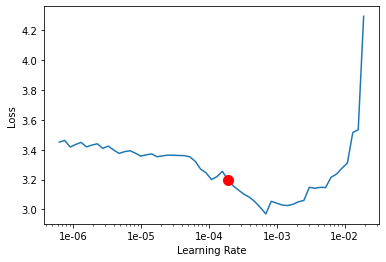

In [47]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

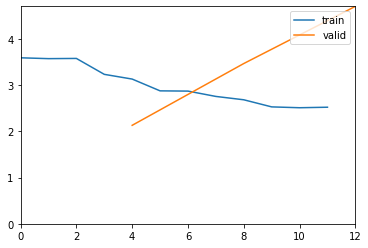

In [48]:
learn.fit_one_cycle(3, 2.75e-4)

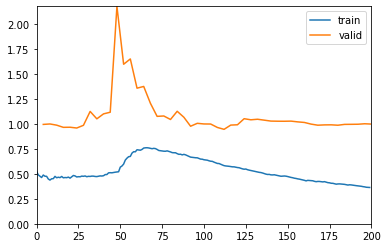

In [82]:
learn.unfreeze()
learn.fit_one_cycle(50, 2.75e-4)

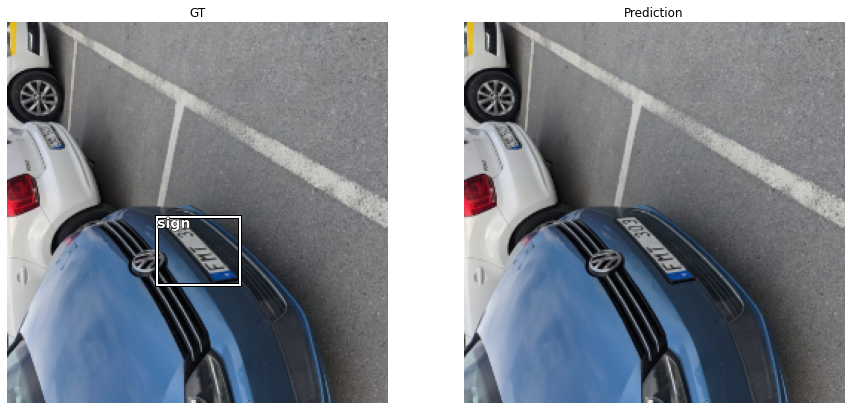

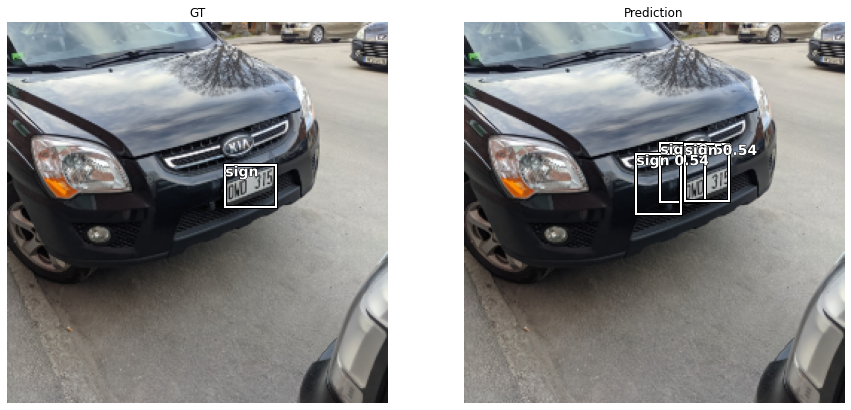

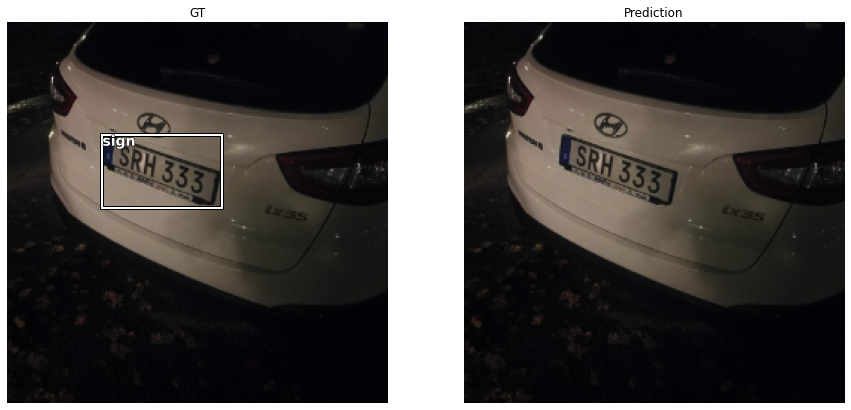

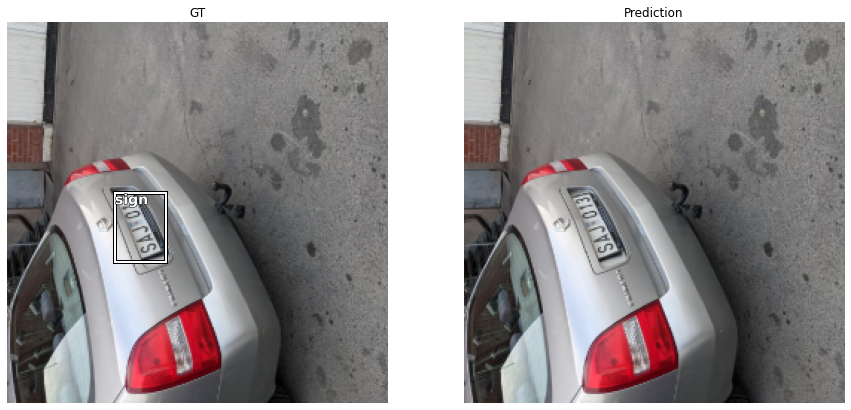

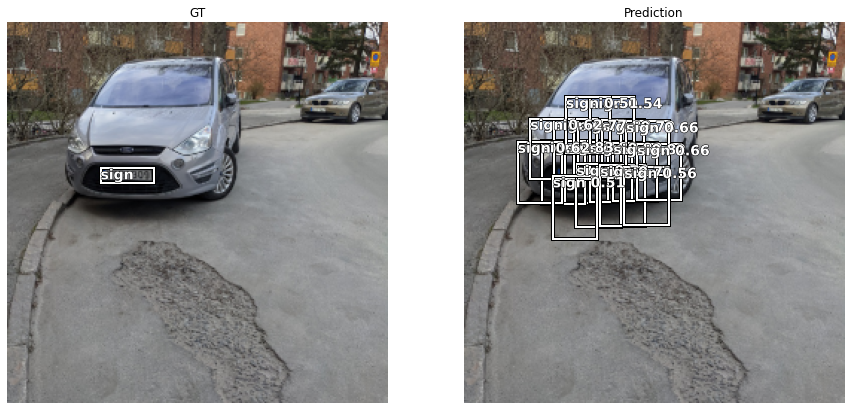

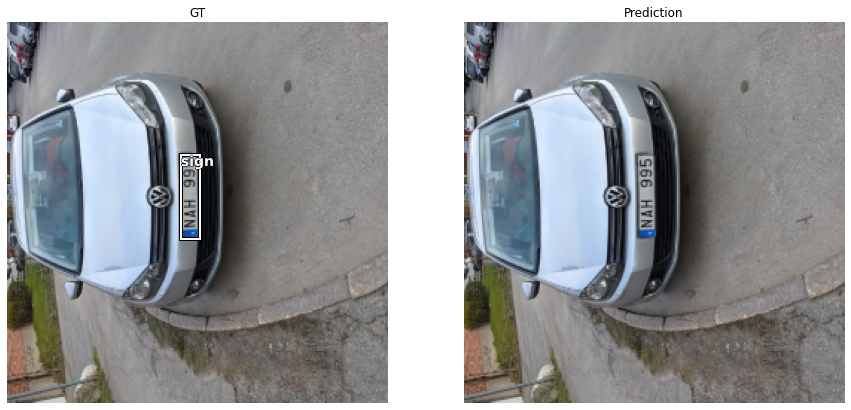

In [67]:
show_results_side_by_side(learn, anchors, detect_thresh=0.5, nms_thresh=0.3, image_count=25)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [106]:
#Export and move to drive 
learn.export
!mv '/root/.fastai/data/cars/export.pkl' 'drive/MyDrive/CarGame/export.pkl'

[PosixPath('/root/.fastai/data/cars/train_sample'),
 PosixPath('/root/.fastai/data/cars/annotations'),
 PosixPath('/root/.fastai/data/cars/export.pkl'),
 PosixPath('/root/.fastai/data/cars/models')]

In [114]:
learn_inf = load_learner("drive/MyDrive/CarGame")

In [20]:
import torchvision.transforms as transforms

In [128]:
def show_result(img, anchors, clas_pred, bbox_pred, classes, detect_thresh:float=0.4, nms_thresh:float=0.4):

    with torch.no_grad():
      img = Image(img)
      bbox_pred, scores, preds = process_output(clas_pred, bbox_pred, anchors, detect_thresh)
      if bbox_pred is not None:
        to_keep = nms(bbox_pred, scores, nms_thresh)
        bbox_pred, preds, scores = bbox_pred[to_keep].cpu(), preds[to_keep].cpu(), scores[to_keep].cpu()

      t_sz = torch.Tensor([*img.size])[None].cpu()

      if bbox_pred is not None:
        bbox_pred = to_np(rescale_boxes(bbox_pred, t_sz))
        # change from center to top left
        bbox_pred[:, :2] = bbox_pred[:, :2] - bbox_pred[:, 2:] / 2

      _, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
      ax.set_title("Prediction")
      # show prediction
      img.show(ax=ax)
      if bbox_pred is not None:
        for bbox, c, scr in zip(bbox_pred, preds, scores):
          txt = str(c.item()) if classes is None else classes[c.item()]
          draw_rect(ax, [bbox[1],bbox[0],bbox[3],bbox[2]], text=f'{txt} {scr:.2f}')

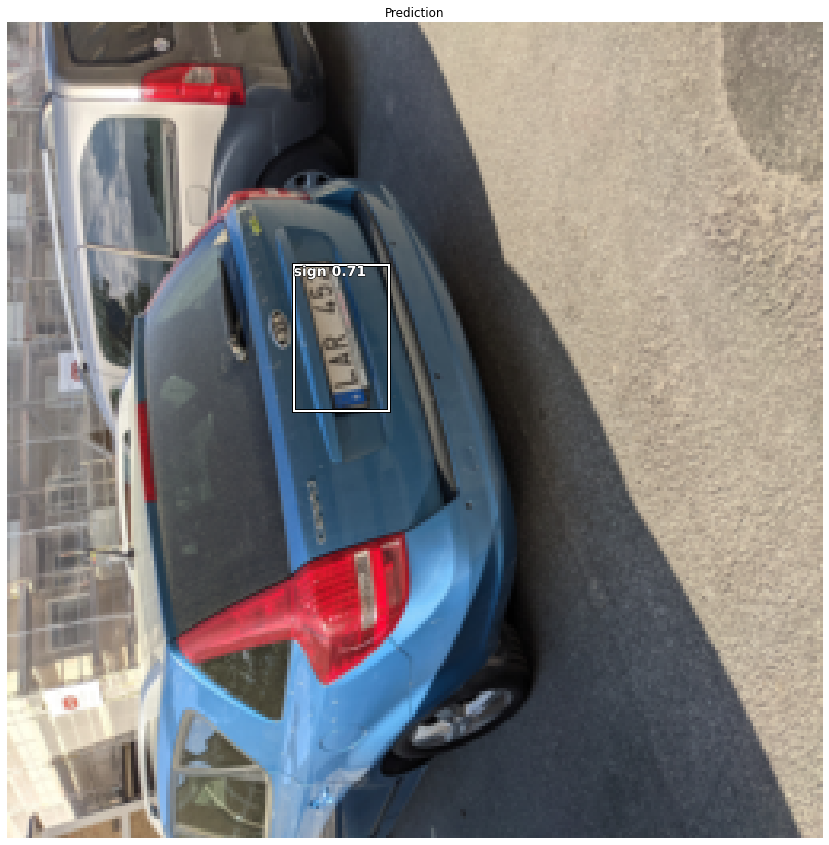

In [135]:
img = PIL.Image.open("/content/drive/MyDrive/CarGame/PXL_20210604_160943226.MP.jpg")
thresh = 0.1
resize = transforms.Resize([256, 256])
img = resize(img)

img = pil2tensor(img,np.float32)
img = img.div_(255)

with torch.no_grad():
  output = learn_inf.model.eval()(img.unsqueeze_(0).cuda())
  clas_pred = output[0][0]
  bbox_pred = output[1][0]
  my_show_result_side(img[0], anchors,clas_pred = clas_pred, bbox_pred=bbox_pred, classes=['background', 'sign'], detect_thresh=thresh, nms_thresh=thresh)